In [178]:
%pip install sortedcontainers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [179]:
#import das bibliotecas necessárias
import matplotlib.pyplot as plt
from functools import cmp_to_key
import numpy as np
import random
from sortedcontainers import SortedList

In [180]:
def orientation(p, q, r):
    """
    Para determinar a orientação do conjunto ordenado (p, q, r).
    Se o resultado for positivo, então a orientação é no sentido horário.
    Se o resultado for negativo, então a orientação é no sentido anti-horário.
    Se o resultado for 0, então p, q e r são colineares.
    """
    return (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)

def on_segment(p, q, r):
    """Verifica se o ponto q está no segmento definido pelos pontos p e r."""
    return (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and
            q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y))

In [181]:
class Ponto:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __sub__(self, other):
        return Ponto(self.x - other.x, self.y - other.y)

    def __repr__(self):
        return f"({self.x}, {self.y})"

    def distancia_ao_quadrado(self, other):
        return (self.x - other.x)**2 + (self.y - other.y)**2

class Segmento:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
    def __repr__(self):
        return f"[{self.p1}, {self.p2}]"
    
    def __hash__(self):
        return hash((self.p1, self.p2))
    
    def __eq__(self, other):
        return isinstance(other, Segmento) and {self.p1, self.p2} == {other.p1, other.p2}
    
    def intersecao(self, other):
        o1 = orientation(self.p1, self.p2, other.p1)
        o2 = orientation(self.p1, self.p2, other.p2)
        o3 = orientation(other.p1, other.p2, self.p1)
        o4 = orientation(other.p1, other.p2, self.p2)

        # Condições principais de interseção
        if o1 * o2 < 0 and o3 * o4 < 0:
            return True

        # Casos especiais: se os segmentos são colineares e se cruzam
        if o1 == 0 and on_segment(self.p1, other.p1, self.p2):
            return True
        if o2 == 0 and on_segment(self.p1, other.p2, self.p2):
            return True
        if o3 == 0 and on_segment(other.p1, self.p1, other.p2):
            return True
        if o4 == 0 and on_segment(other.p1, self.p2, other.p2):
            return True

        return False


    
    def produto_vetorial(self, other):
        return (self.p2.x - self.p1.x) * (other.p2.y - other.p1.y) - (self.p2.y - self.p1.y) * (other.p2.x - other.p1.x)
    
    def __lt__(self, other):
        return self.p1.y < other.p1.y or (self.p1.y == other.p1.y and self.p2.y < other.p2.y)

    def __eq__(self, other):
        return self.p1.y == other.p1.y and self.p2.y == other.p2.y

In [182]:
def ordenacao_polar(p0):
    def compare(p1, p2):
        o = orientation(p0, p1, p2)
        if o == 0:
            return (p1.distancia_ao_quadrado(p0) <= p2.distancia_ao_quadrado(p0)) - 1
        return 1 if o > 0 else -1
    return compare


In [183]:
#Algoritmo de Graham Scan para criar a envoltoŕia convexa

def graham_scan(pontos):
    pontos = sorted(pontos, key=lambda p: (p.y, p.x))
    p0 = pontos[0]
    pontos_ordenados = sorted(pontos[1:], key=cmp_to_key(ordenacao_polar(p0)))

    envoltoria = [p0, pontos_ordenados[0]]
    for p in pontos_ordenados[1:]:
        # Enquanto a orientação não for anti-horária, remova o último ponto
        while len(envoltoria) > 1 and Segmento(envoltoria[-2], envoltoria[-1]).produto_vetorial(Segmento(envoltoria[-1], p)) <= 0:
            envoltoria.pop()
        envoltoria.append(p)

    # Fechar a envoltória
    if len(envoltoria) > 2:
        envoltoria.append(p0)

    return envoltoria


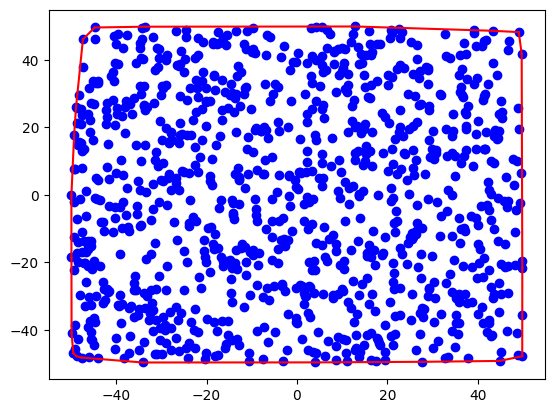

In [184]:
# Função para plotar a envoltória convexa

def plot_envoltoria(pontos, envoltoria):
    # Plotar todos os pontos
    plt.scatter([p.x for p in pontos], [p.y for p in pontos], color='b')

    # Plotar a envoltória convexa
    for i in range(len(envoltoria) - 1):
        plt.plot([envoltoria[i].x, envoltoria[i+1].x], [envoltoria[i].y, envoltoria[i+1].y], color='r')
    
    # Fechar a envoltória
    plt.plot([envoltoria[-1].x, envoltoria[0].x], [envoltoria[-1].y, envoltoria[0].y], color='r')
    
    plt.show()

# Gerar pontos aleatórios para testar o algoritmo e posteriormente plotar a envoltória convexa
pontos = [Ponto(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(1000)]
envoltoria = graham_scan(pontos)
plot_envoltoria(pontos, envoltoria)


In [185]:
def segmentos_que_se_cruzam(segmentos, poligonos):
    # Criar eventos
    eventos = []
    for seg, poligono in zip(segmentos, poligonos):
        start = seg.p1 if seg.p1.x < seg.p2.x else seg.p2
        end = seg.p2 if seg.p1.x < seg.p2.x else seg.p1
        eventos.append((start, 'start', seg, poligono))
        eventos.append((end, 'end', seg, poligono))
    
    # Ordenar eventos
    eventos.sort(key=lambda e: (e[0].x, e[0].y))

    def order_by_y(segment):
        return (segment.p1.y + segment.p2.y) / 2

    ordenacao_y = SortedList(key=order_by_y)
    intersecoes = set()

    # Processar eventos
    for ponto, tipo, segmento, poligono in eventos:
        if tipo == 'start':
            idx = ordenacao_y.bisect(segmento)
            
            # Verificar interseção com segmento abaixo
            if idx > 0:
                seg_below = ordenacao_y[idx - 1]
                if segmento.intersecao(seg_below) and poligonos[segmentos.index(segmento)] != poligonos[segmentos.index(seg_below)]:
                    intersecoes.add(tuple(sorted([segmento, seg_below])))

            # Verificar interseção com segmento acima
            if idx < len(ordenacao_y) - 1:
                seg_above = ordenacao_y[idx + 1]
                if segmento.intersecao(seg_above) and poligonos[segmentos.index(segmento)] != poligonos[segmentos.index(seg_above)]:
                    intersecoes.add(tuple(sorted([segmento, seg_above])))

            ordenacao_y.add(segmento)
        else:
            segmento_idx = ordenacao_y.index(segmento)
            
            # Verificar interseção entre segmentos vizinhos
            if 0 < segmento_idx < len(ordenacao_y) - 1:
                seg_below = ordenacao_y[segmento_idx - 1]
                seg_above = ordenacao_y[segmento_idx + 1]
                if seg_below.intersecao(seg_above) and poligonos[segmentos.index(seg_below)] != poligonos[segmentos.index(seg_above)]:
                    intersecoes.add(tuple(sorted([seg_below, seg_above])))
            
            ordenacao_y.remove(segmento)
    
    return list(intersecoes)



def plot_segmentos(segmentos):
    """Plota os segmentos e destaca aqueles que se cruzam."""
    intersecoes = segmentos_que_se_cruzam(segmentos)
    for segmento in segmentos:
        plt.plot([segmento.p1.x, segmento.p2.x], [segmento.p1.y, segmento.p2.y], 'b-')

    for seg1, seg2 in intersecoes:
        plt.plot([seg1.p1.x, seg1.p2.x], [seg1.p1.y, seg1.p2.y], 'b-')
        plt.plot([seg2.p1.x, seg2.p2.x], [seg2.p1.y, seg2.p2.y], 'b-')

    plt.show()

In [186]:

def envoltorias_sao_independentes(envoltoria1, envoltoria2):
    segmentos1 = [Segmento(envoltoria1[i], envoltoria1[i + 1]) for i in range(len(envoltoria1) - 1)]
    segmentos2 = [Segmento(envoltoria2[i], envoltoria2[i + 1]) for i in range(len(envoltoria2) - 1)]
    
    todos_segmentos = segmentos1 + segmentos2
    poligonos = [1] * len(segmentos1) + [2] * len(segmentos2)
    
    intersecoes = segmentos_que_se_cruzam(todos_segmentos, poligonos)

    if len(intersecoes) == 0:
        print("As envoltórias são independentes")
        return True
    else:
        print("As envoltórias não são independentes")
        return False

In [187]:
def plot_envoltorias(envoltoria1, envoltoria2):
    # Verifica se as envoltórias se cruzam
    sao_independentes = envoltorias_sao_independentes(envoltoria1, envoltoria2)
    
    # Plotar envoltória 1 em vermelho
    for i in range(len(envoltoria1) - 1):
        plt.plot([envoltoria1[i].x, envoltoria1[i+1].x], [envoltoria1[i].y, envoltoria1[i+1].y], color='r')
    plt.plot([envoltoria1[-1].x, envoltoria1[0].x], [envoltoria1[-1].y, envoltoria1[0].y], color='r')
    
    # Plotar envoltória 2 em azul
    for i in range(len(envoltoria2) - 1):
        plt.plot([envoltoria2[i].x, envoltoria2[i+1].x], [envoltoria2[i].y, envoltoria2[i+1].y], color='b')
    plt.plot([envoltoria2[-1].x, envoltoria2[0].x], [envoltoria2[-1].y, envoltoria2[0].y], color='b')
    
    plt.show()

As envoltórias são independentes


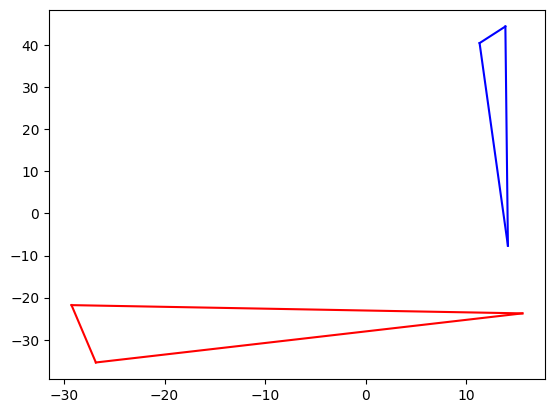

In [202]:
# Exemplo de uso
pontos1 = [Ponto(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(3)]
pontos2 = [Ponto(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(3)]
envoltoria1 = graham_scan(pontos1)
envoltoria2 = graham_scan(pontos2)
plot_envoltorias(envoltoria1, envoltoria2)